In [0]:
# setup block. Defines various utilities for reading in the data, metrics for training, as well as loading all dependencies
#Thank you to Mayukh for the starting code, especially the generators, metrics and submission building https://github.com/mayukh18/Google-Landmark-Recognition-Retrieval-2019
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu
!pip -m pip install git+https://github.com/raghakot/keras-vis.git

import faiss
%tensorflow_version 1.14
import numpy as np
import pandas as pd 
import keras
from keras.applications import ResNet50
from keras.layers import Layer
from keras import regularizers
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, \
    GlobalAveragePooling2D, Lambda, MaxPooling2D, Reshape, Dropout
from keras.models import Model
from keras.optimizers import Adam
from collections import Counter
from shutil import copyfile
import random
import shutil
import tarfile
import cv2
from keras.utils import Sequence
import cv2
import urllib
import requests
from tqdm import tqdm
import json
import pickle
import sys
from keras.models import load_model
import os
from keras.applications.imagenet_utils import decode_predictions
import multiprocessing as mp
from joblib import Parallel, delayed
from google.colab import files
from keras.models import Sequential
from keras.layers import Dense, Activation

from vgg16_places_365 import VGG16_Places365


def check_size(url):
    """
    Helper method to check the size of the file from the url
    """
    r = requests.get(url, stream=True)
    return int(r.headers['Content-Length'])


def download_file(url, filename, bar=True):
    """
    Helper method handling downloading large files from `url` to `filename`. Returns a pointer to `filename`.
    """
    try:
        chunkSize = 1024
        r = requests.get(url, stream=True)
        with open(filename, 'wb') as f:
            if bar:
                pbar = tqdm(unit="B", total=int(r.headers['Content-Length']))
            for chunk in r.iter_content(chunk_size=chunkSize):
                if chunk:  # filter out keep-alive new chunks
                    if bar:
                        pbar.update(len(chunk))
                    f.write(chunk)
        return filename
    except Exception as e:
        print(e)
        return


def download_image_cv2_urllib(url):
    """
    Modifying the url to download the 360p or 720p version actually slows it down.
    """
    try:
        resp = urllib.request.urlopen(url)
        foo = np.asarray(bytearray(resp.read()), dtype="uint8")
        foo = cv2.imdecode(foo, cv2.IMREAD_COLOR)
        foo = cv2.resize(foo, (192, 192), interpolation=cv2.INTER_AREA)
        foo = cv2.cvtColor(foo, cv2.COLOR_BGR2RGB)
        return foo
    except:
        return np.array([])
    
import numpy as np
import tensorflow as tf
import keras.backend as K




def accuracy_class(y_true, y_pred):
    true = K.argmax(y_true, axis=1)
    pred = K.argmax(y_pred, axis=1)
    matches = K.equal(true, pred)
    return K.mean(matches)


def accuracy_class_numpy(y_true, y_pred):
    true = np.argmax(y_true, axis=1)
    pred = np.argmax(y_pred, axis=1)
    matches = true == pred
    return np.mean(matches)


def getConfidence(y_pred):
    y_pred_max = np.reshape(np.amax(y_pred, axis=1), (y_pred.shape[0], 1))

    top5 = np.zeros((y_pred.shape[0], 5))
    max_indices = np.argsort(y_pred, axis=1)[:, ::-1][:, :5]
    for i in range(y_pred.shape[0]):
        top5[i, :] = y_pred[i, max_indices[i, :]]
    diff = y_pred_max - top5
    weights = np.array([[0., 0.35, 0.28, 0.22, 0.15]])
    weighted_diffs = diff * weights
    return np.sum(weighted_diffs, axis=1)


def getOrder(y_pred):
    summ = getConfidence(y_pred)
    summ_indices = np.argsort(summ)[::-1]
    return summ_indices


def MAP_numpy(y_true, y_pred):
    true = np.argmax(y_true, axis=1)
    pred = np.argmax(y_pred, axis=1)
    matches = true == pred

    order = getOrder(y_pred)
    orderedMatches = matches[order]

    correct = 0.
    summ = 0.
    for i in range(y_true.shape[0]):
        correct += int(orderedMatches[i])
        summ += (correct / (i + 1)) * int(orderedMatches[i])
    return summ / y_true.shape[0]

class DataGen(Sequence):
    """
    This generator downloads one tar file at each epoch. Extracts and selects the valid images from it to
    form batches. And after the epoch is complete, deletes the files to free up space.
    """
    def __init__(self, valid_ids_dict, num_classes, start=10, batch_size=128, steps=10, verbose=1):

        self.valid_ids_dict = valid_ids_dict # dict of image ids to landmarks {image_id: landmark_id}
        self.NUM_CLASSES = num_classes # number of valid classes to consider

        self.batch_size = batch_size
        self.steps = steps # should be equal to the number of epochs
        self.images = []
        self.landmarks = []
        self.tar_idx = start
        self.epoch_init()

    def epoch_init(self):
        self.all_images = []
        self.all_landmarks = []

        if self.tar_idx < 10:
            tarfilestr = "00" + str(self.tar_idx)
        elif self.tar_idx < 100:
            tarfilestr = "0" + str(self.tar_idx)
        else:
            tarfilestr = str(self.tar_idx)

        download_file("https://s3.amazonaws.com/google-landmark/train/images_{}.tar".format(tarfilestr), "images.tar",
                      bar=False)
        tar = tarfile.open('images.tar')
        tar.extractall("imagesfolder")
        tar.close()

        self.total = self.pickfiles("imagesfolder")
        self.tar_idx += 1
        print("tar", self.tar_idx - 1, "total:", self.total)

    def pickfiles(self, dirr):
        count = 0
        for f in os.listdir(dirr):
            if os.path.isfile(dirr + "/" + f):
                if f[:-4] in self.valid_ids_dict:
                    self.all_images.append(dirr + "/" + f)
                    self.all_landmarks.append(self.valid_ids_dict[f[:-4]])
                    count += 1
            else:
                count += self.pickfiles(dirr + "/" + f)
        return count

    def normalize(self, data):
        return data / 255 - 0.5

    def __getitem__(self, index):
        image_path_list = self.all_images[index * self.batch_size:min(self.total, (index + 1)) * self.batch_size]
        class_list = self.all_landmarks[index * self.batch_size:min(self.total, (index + 1)) * self.batch_size]

        if len(image_path_list) == 0:
            image_path_list = self.all_images[:self.batch_size]
            class_list = self.all_landmarks[:self.batch_size]

        images = []
        y_list = []
        for ix in range(len(image_path_list)):
            try:
                image_path = image_path_list[ix]
                im = cv2.imread(image_path)
                im = cv2.resize(im, (192, 192), interpolation=cv2.INTER_AREA)
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                if im.shape == (192, 192, 3):
                    images.append(im)
                    y_list.append(class_list[ix])
            except:
                continue

        x = np.array(images)
        y = np.zeros((len(y_list), self.NUM_CLASSES))

        for i in range(len(y_list)):
            y[i, y_list[i]] = 1.

        return x, y

    def on_epoch_end(self):
        self.steps -= 1
        os.unlink("images.tar")
        shutil.rmtree("imagesfolder")
        if self.steps > 0:
            self.epoch_init()

    def __len__(self):
        return self.total // self.batch_size + int(self.total % self.batch_size > 0)
    
def isImageLandmark(categories, conf, label):
  index = 0 
  for (i, c) in enumerate(categories):
      if label in c:
          index = i

  MIN_CONF = 0.7

  if conf < MIN_CONF:
      return True
    
  if i in [403, 405, 406, 410, 412, 415, 417, 421, 425, 436, 437, 447, 448, 449, 454, 458, 467, 468, 472, 471, 476, 483, 484, 488, 489, 493, 494, 497, 498, 500, 502, 
    509, 510, 513, 516, 517, 519, 522, 524, 525, 548, 555, 557, 565, 576, 577, 579, 580, 582, 595, 598, 599, 802, 600, 601, 607, 616, 621, 624, 625, 628, 634, 646,
    649, 660, 663, 665, 668, 672, 682, 693, 706, 703, 708, 716, 727, 730, 734, 741, 743, 762, 775, 779, 780, 788, 795, 796, 802, 812, 814, 815, 817, 819, 818, 820, 821,
    825, 829, 832, 833, 835, 847, 854, 857, 865, 866, 867, 874, 874, 858, 883, 884, 904, 905, 912, 915, 919, 920, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980,
    983, 991]:

    return True
  
  return False





Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Requirement already up-to-date: faiss in /usr/local/lib/python3.6/dist-packages (1.5.3)
Requirement already up-to-date: faiss-gpu in /usr/local/lib/python3.6/dist-packages (1.6.3)

Usage:   
  pip3 <command> [options]

no such option: -m
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
# ------------------------------ form the dataset ------------------------------ #

download_file("https://s3.amazonaws.com/google-landmark/metadata/train.csv", "train.csv")
train = pd.read_csv("train.csv")

print(train.head())
print(train.shape)
print("Number of classes {}".format(len(train.landmark_id.unique())))

NUM_THRESHOLD = 20 #how many of a class to consider a non-outlier

counts = dict(Counter(train['landmark_id']))

#------------------ downsample the train set ----------------------#
#       comment block out if csv is already generated
#       grabs top N of each class that has at least NUM_THRESHHOLD instances
#       comment out when training, only used for similarity searches on pretraining models


# groups = train.groupby('landmark_id')


# down_sampled = pd.DataFrame(columns=['id', 'landmark_id'])
# for g in groups:

#   if len(g[1]) >= NUM_THRESHOLD:
#     data = {
#         'id': [v.split()[-1] for v in sorted(g[1]['id'])[:5]],
#         'landmark_id': [g[0] for i in range(5)]
#     }
#     df = pd.DataFrame(data = data)
#     down_sampled = down_sampled.append(df, ignore_index=True)


# down_sampled.to_csv(r'/content/drive/My Drive/valid_train_examples.csv', index = False)
# print("Put values in new csv")




# ----------  uncomment to load csv instead of filter --------------
down_sampled = pd.read_csv("/content/drive/My Drive/valid_train_examples_2.csv")


# --------------------- Setup landmarks and train data dicts for later lookup -----------


landmarks_dict = {x:[] for x in train.landmark_id.unique() if counts[x] >= NUM_THRESHOLD and x != 138982}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

i = 0
landmark_to_idx = {}
idx_to_landmark = []
for k in landmarks_dict:
    landmark_to_idx[k] = i
    idx_to_landmark.append(k)
    i += 1

all_ids = down_sampled['id'].tolist()
all_landmarks = down_sampled['landmark_id'].tolist()
valid_ids_dict = {x[0].split("/")[-1]:landmark_to_idx[x[1]] for x in zip(all_ids, all_landmarks) if x[1] in landmarks_dict}
valid_ids_list = [x[0] for x in zip(all_ids, all_landmarks) if x[1] in landmarks_dict]

NUM_EXAMPLES = len(valid_ids_list)
print("Total number of valid examples: {}".format(NUM_EXAMPLES))




# ---------------------  Save off tars needed for down sampled data -------------
#                        Useful if you want to run similarity searches using less data
#                        Comment out if training or if using full data set
#                        Comment out if already generated

# def getImages(tar_idx):
#   if tar_idx < 10:
#     tarfilestr = "00" + str(tar_idx)
#   elif tar_idx < 100:
#     tarfilestr = "0" + str(tar_idx)
#   else:
#     tarfilestr = str(tar_idx)
#   download_file("https://s3.amazonaws.com/google-landmark/train/images_{}.tar".format(tarfilestr), f"images{tarfilestr}.tar",bar=False)
#   tar = tarfile.open(f'images{tarfilestr}.tar')
#   tar.extractall(f'images{tarfilestr}')
#   tar.close()

#   os.unlink(f"images{tarfilestr}.tar")

#   def pickfiles(dirr):
#     count = 0 
#     for f in os.listdir(dirr):
#       if count > 0:
#           break
#       if os.path.isfile(dirr + "/" + f):
#         if f[:-4] in valid_ids_dict:
#           count += 1
#       else:
#         count += pickfiles(dirr + "/" + f)
#     return count


#   total = pickfiles(f"images{tarfilestr}")

#   shutil.rmtree(f"images{tarfilestr}")
#   if (total > 0):
#     return tar_idx
#   else:
#     return -1


# num_cores = mp.cpu_count()
# pool = mp.Pool(processes=num_cores)

# for i in range(10):

#   print(f"block {i}")
#   r = range(i*50, (i+1)*50)
#   x = pool.map(getImages, r)
#   allTarsWithValues = list(set([y for y in x if y > 0]))

#   import pickle
#   pickle.dump(allTarsWithValues, open(f'/content/drive/My Drive/save{i}.p', 'wb'))



# -------------- builds set from existing files -------------
#                comment out if using full data set or if training


allTarsWithValues = [] 

for i in range(10):
  temp = pickle.load(open(f'/content/drive/My Drive/save{i}_2.p', 'rb'))
  allTarsWithValues.append(temp)

allTarsWithValues = np.concatenate(allTarsWithValues)
allTarsWithValues = [int(i) for i in allTarsWithValues]
print(allTarsWithValues)

 99%|█████████▉| 523064320/525832518 [00:11<00:00, 38706342.45B/s]

                 id  ... landmark_id
0  6e158a47eb2ca3f6  ...      142820
1  202cd79556f30760  ...      104169
2  3ad87684c99c06e1  ...       37914
3  e7f70e9c61e66af3  ...      102140
4  4072182eddd0100e  ...        2474

[5 rows x 3 columns]
(4132914, 3)
Number of classes 203094
Total number of valid classes: 52583
Total number of valid examples: 262915
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 150,

In [0]:
# ------------------------------------- validation ------------------------------------------------- #
#                             sets up validation set from the first training tar file
#                             comment out if not training


# download_file("https://s3.amazonaws.com/google-landmark/train/images_001.tar", "validation.tar", bar=False)
# tar = tarfile.open('validation.tar')
# tar.extractall("validation")
# tar.close()

# os.unlink("validation.tar")

# print(os.listdir())

# validation_images_paths = []
# validation_landmarks = []


# def pickfiles(dirr):
#     count = 0
#     for f in os.listdir(dirr):
#         if os.path.isfile(dirr + "/" + f):
#             if f[:-4] in valid_ids_dict:
#                 validation_images_paths.append(dirr + "/" + f)
#                 validation_landmarks.append(valid_ids_dict[f[:-4]])
#                 count += 1
#         else:
#             count += pickfiles(dirr + "/" + f)
#     return count


# total = pickfiles("validation")
# print("total:", total)

# validation_images = []

# for image_path in validation_images_paths:
#     im = cv2.imread(image_path)
#     im = cv2.resize(im, (192, 192), interpolation=cv2.INTER_AREA)
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     validation_images.append(im)

# valid_x = np.array(validation_images)
# valid_y = np.zeros((len(validation_landmarks), NUM_CLASSES))

# for i in range(len(validation_landmarks)):
#     valid_y[i, validation_landmarks[i]] = 1.

# shutil.rmtree("validation")
# del validation_images


# ------------------------------------ model ----------------------------------------- #
#                            comment out if not training, defines initial model
res = ResNet50(include_top=False, weights='imagenet', input_shape=(192, 192, 3))

for layer in res.layers:
    layer.trainable = True

out = GlobalMaxPooling2D()(res.output)
out = Dense(NUM_CLASSES, activation='softmax')(out)
model3 = Model(res.input, out)
model3.summary()




# ----------------------------------- training ---------------------------------------- #
#                             trains in mini-epochs on each tar file
#                             comment out if not training
#                       saves file to drive at set checkpoints for restarting if disconnected


# EPOCHS = 170
# opt = Adam(0.0002)
# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[accuracy_class])
# model.fit_generator(generator=DataGen(valid_ids_dict, NUM_CLASSES, start=10, batch_size=64,steps=EPOCHS),
#                    epochs=EPOCHS,
#                    validation_data = [valid_x, valid_y],
#                    use_multiprocessing=True,
#                    workers=8,
#                    verbose=2)

# model.save('my_model3.h5')  # creates a HDF5 file 'my_model.h5'
# print("model saved")

# model = load_model(F'/content/drive/My Drive/my_model3.h5', custom_objects={
#         "accuracy_class": accuracy_class
#     })
# print("loaded model")

# EPOCHS = 50
# opt = Adam(0.0001)
# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[accuracy_class])
# model.fit_generator(generator=DataGen(valid_ids_dict, NUM_CLASSES, start=180, batch_size=48,steps=EPOCHS),
#                     epochs=EPOCHS,
#                     validation_data = [valid_x, valid_y],
#                     use_multiprocessing=True,
#                     workers=4,
#                     verbose=2)

# model.save(F'/content/drive/My Drive/my_model2.h5')  # creates a HDF5 file 'my_model.h5'
# print("model saved")

# model = load_model(F'/content/drive/My Drive/my_model2.h5', custom_objects={
#         "accuracy_class": accuracy_class
#     })
# print("loaded model")

# EPOCHS = 50
# opt = Adam(0.0001)
# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[accuracy_class])
# model.fit_generator(generator=DataGen(valid_ids_dict, NUM_CLASSES, start=230, batch_size=48,steps=EPOCHS),
#                     epochs=EPOCHS,
#                     validation_data = [valid_x, valid_y],
#                     use_multiprocessing=True,
#                     workers=4,
#                     verbose=2)

# model.save(F'/content/drive/My Drive/my_model2.h5')  # creates a HDF5 file 'my_model.h5'
# print("model saved")

# model = load_model(F'/content/drive/My Drive/my_model2.h5', custom_objects={
#          "accuracy_class": accuracy_class
#      })
# print("loaded model")

# EPOCHS = 50
# opt = Adam(0.0001)
# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[accuracy_class])
# model.fit_generator(generator=DataGen(valid_ids_dict, NUM_CLASSES, start=230, batch_size=48,steps=EPOCHS),
#                     epochs=EPOCHS,
#                     validation_data = [valid_x, valid_y],
#                     use_multiprocessing=True,
#                     workers=4,
#                     verbose=2)

# model.save(F'/content/drive/My Drive/my_model2.h5')  # creates a HDF5 file 'my_model.h5'
# print("model saved")


# model = load_model(F'/content/drive/My Drive/my_model2.h5', custom_objects={
#         "accuracy_class": accuracy_class
#     })
# print("loaded model")

# EPOCHS = 50
# opt = Adam(0.00004)
# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[accuracy_class])
# model.fit_generator(generator=DataGen(valid_ids_dict, NUM_CLASSES, start=340, batch_size=48,steps=EPOCHS),
#                     epochs=EPOCHS,
#                     validation_data = [valid_x, valid_y],
#                     use_multiprocessing=True,
#                     workers=4,
#                     verbose=2)

# model.save(F'/content/drive/My Drive/my_model1.h5')  # creates a HDF5 file 'my_model.h5'
# print("model saved")

# model = load_model(F'/content/drive/My Drive/my_model1.h5', custom_objects={
#          "accuracy_class": accuracy_class
#      })
# print("loaded model")

# EPOCHS = 50
# opt = Adam(0.00002)
# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[accuracy_class])
# model.fit_generator(generator=DataGen(valid_ids_dict, NUM_CLASSES, start=390, batch_size=48,steps=EPOCHS),
#                     epochs=EPOCHS,
#                     validation_data = [valid_x, valid_y],
#                     use_multiprocessing=True,
#                     workers=4,
#                     verbose=2)

# model.save(F'/content/drive/My Drive/my_model.h5')  # creates a HDF5 file 'my_model.h5'
# print("model saved")

# model = load_model(F'/content/drive/My Drive/my_model1.h5', custom_objects={
#         "accuracy_class": accuracy_class
#     })
# print("loaded model")

# EPOCHS = 60
# opt = Adam(0.00002)
# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[accuracy_class])
# model.fit_generator(generator=DataGen(valid_ids_dict, NUM_CLASSES, start=440, batch_size=48,steps=EPOCHS),
#                     epochs=EPOCHS,
#                     validation_data = [valid_x, valid_y],
#                     use_multiprocessing=True,
#                     workers=4,
#                     verbose=2)
#

# model.save(F'/content/drive/My Drive/my_model.h5')  # creates a HDF5 file 'my_model.h5'
# print("model saved")
# del model  # deletes the existing model



# ----------------- load in pretrained model ---------------------
#           rename to model2 to model if not using similarity search 
#           
model2 = load_model(F'/content/drive/My Drive/my_model.h5', custom_objects={
        "accuracy_class": accuracy_class
    })
print("loaded model")



# --------------- pops off the last layer of model for feature extraction ----------------
#                 comment out if not doing similarity searches
model = Model(model2.input, model2.layers[-2].output)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 96, 96, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
# ------------------------ build similarity search index -------------------
#                       comment out full block if not doing similarity search

inputs = allTarsWithValues

train_predictions = []
landmarks = []


def getImages(tar_idx):
  if tar_idx < 10:
    tarfilestr = "00" + str(tar_idx)
  elif tar_idx < 100:
    tarfilestr = "0" + str(tar_idx)
  else:
    tarfilestr = str(tar_idx)
  download_file("https://s3.amazonaws.com/google-landmark/train/images_{}.tar".format(tarfilestr), f"images{tarfilestr}.tar",bar=False)
  tar = tarfile.open(f'images{tarfilestr}.tar')
  tar.extractall(f'images{tarfilestr}')
  tar.close()
  os.unlink(f"images{tarfilestr}.tar")
  images_paths = []
  def pickfiles(dirr):
    count = 0 
    for f in os.listdir(dirr):
       if os.path.isfile(dirr + "/" + f):
         if f[:-4] in valid_ids_dict:
           images_paths.append(dirr + "/" + f)
           landmarks.append(f[:-4])
           count += 1
       else:
         count += pickfiles(dirr + "/" + f)
    return count
  
  total = pickfiles(f"images{tarfilestr}")
  sub_images = []
  print("total:", total)    
  for image_path in images_paths:
    im = cv2.imread(image_path)
    im = cv2.resize(im, (192, 192), interpolation=cv2.INTER_AREA)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    sub_images.append(im)
    
  preds = model.predict(np.array(sub_images))
  train_predictions.extend(preds)
  shutil.rmtree(f"images{tarfilestr}")


# for i in inputs:
#   getImages(i)

# pickle.dump(landmarks, open(f'/content/drive/My Drive/landmarks.p', 'wb'))
# pickle.dump(train_predictions, open(f'/content/drive/My Drive/vectors.p', 'wb'))
train_predictions = pickle.load(open(f'/content/drive/My Drive/vectors_2.p', 'rb'))
landmarks = pickle.load(open(f'/content/drive/My Drive/landmarks_2.p', 'rb'))
print("\r\n Done gathering images... \r\n")


total: 6121
total: 5940
total: 5890
total: 5788
total: 5653
total: 5512
total: 5438
total: 5262
total: 5053
total: 5032
total: 4881
total: 4697
total: 4653
total: 4469
total: 4354
total: 4289
total: 4223
total: 4023
total: 3986
total: 3793
total: 3739
total: 3710
total: 3578
total: 3582
total: 3394
total: 3309
total: 3342
total: 3239
total: 3204
total: 3047
total: 2951
total: 2878
total: 2799
total: 2762
total: 2694
total: 2611
total: 2567
total: 2549
total: 2448
total: 2393
total: 2367
total: 2259
total: 2225
total: 2243
total: 2175
total: 2153
total: 2091
total: 1998
total: 1921
total: 1891
total: 1897
total: 1804
total: 1935
total: 1724
total: 1734
total: 1665
total: 1597
total: 1594
total: 1549
total: 1481
total: 1504
total: 1457
total: 1458
total: 1353
total: 1372
total: 1348
total: 1252
total: 1312
total: 1228
total: 1261
total: 1172
total: 1206
total: 1157
total: 1093
total: 999
total: 1033
total: 1085
total: 1015
total: 974
total: 968
total: 892
total: 872
total: 931
total: 850

In [0]:
from faiss import normalize_L2

train_predictions = np.array(train_predictions)
d = 2048
index = faiss.IndexFlatL2(d)
normalize_L2(train_predictions)
index.add(train_predictions)


In [0]:
# -------------------------------------------- prediction ------------------------------------------------ #
#                               generates predictions for the final submission
#                               manual edits needed for switching between similarity search and raw model
#                               view comments to see what needs to be swapped out


import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

import time

tm = time.time()


tar_images = []
tar_ids = []
    

with open(F'/content/drive/My Drive/imagenet1000.txt') as f:
  imagenet = eval(f.read())

discrim_model_2 = ResNet50(include_top=True, weights='imagenet', input_shape=(224, 224, 3))

# Places365 Model
discrim_model = VGG16_Places365(weights='places')    
class_information = pd.read_csv(F'/content/drive/My Drive/categories_places365_extended.csv')
final_ids = []
final_conf = []
final_preds = []

for tar in range(20):
    if tar < 10:
        tar_id = "00" + str(tar)
    else:
        tar_id = "0" + str(tar)

    tar_images = []
    tar_ids = []

    def pickfiles(dirr):
      count = 0
      for f in os.listdir(dirr):
        if os.path.isfile(dirr + "/" + f):
            tar_images.append(dirr + "/" + f)
            tar_ids.append(f[:-4])
            count += 1
        else:
            count += pickfiles(dirr + "/" + f)
      return count

    download_file("https://s3.amazonaws.com/google-landmark/test/images_{}.tar".format(tar_id), f"images{tar_id}.tar", bar=False)
    tar = tarfile.open(f'images{tar_id}.tar')
    tar.extractall(f"imagesfolder{tar_id}")
    tar.close()

    os.unlink(f"images{tar_id}.tar")

    total = pickfiles(f"imagesfolder{tar_id}")
    print(tar, total, len(tar_ids))
        
    
    N = total
    batchsize = 1000
    conf_list = []
    y_pred_list = []
    validM = N // batchsize + int(N % batchsize > 0)


    categories = list(imagenet.values())

    topn = 5
    for i in range(validM):
        temp = tar_images[i * batchsize:min(N, (i + 1) * batchsize)]
        batch_images = []
        batch_images_2 = []
        for t in temp:
            im = cv2.imread(t)
            im = cv2.resize(im, (192, 192), interpolation=cv2.INTER_AREA)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            batch_images.append(im)
        for t in temp:
            im = cv2.imread(t)
            im = cv2.resize(im, (224, 224), interpolation=cv2.INTER_AREA)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            batch_images_2.append(im)


        # ------------------- landmark discriminator -------------------
        #           tracks number of predictions classified as landmark
        #           makes prediction blank if threshhold isn't met


        p0, p1, p2 = [], [], []
        isLandmark = []
        batch_images = np.array(batch_images)
        batch_images_2 = np.array(batch_images_2)
        all_preds = discrim_model_2.predict(batch_images_2, use_multiprocessing=True, workers = 8, batch_size=128)
        all_preds = decode_predictions(all_preds)
        # Loop through all images
        for (i, image) in enumerate(batch_images_2):
    
            # Predict Top N Image Classes
            image = np.expand_dims(image, 0)
            topn_preds = np.argsort(discrim_model.predict(image)[0])[::-1][0:topn]
            image_preds = all_preds[i]

            images0 = image_preds[0]
            images1 = image_preds[1]
            images2 = image_preds[2]
            images3 = image_preds[3]
            num_landmark = 0
            if (isImageLandmark(categories, images0[2], images0[1])):
                num_landmark += 1
              
            if (isImageLandmark(categories, images1[2], images1[1])):
                num_landmark += 1

            if (isImageLandmark(categories, images2[2], images2[1])):
                num_landmark += 1
          
            places0 = topn_preds[0]
            places1 = topn_preds[1]
            places2 = topn_preds[2]
            p0_landmark = class_information.loc[places0, ['landmark']][0]
            p1_landmark = class_information.loc[places1, ['landmark']][0]
            p2_landmark = class_information.loc[places2, ['landmark']][0]
            if (p0_landmark == 1): 
                num_landmark += 1
            if (p1_landmark == 1):
                num_landmark += 1
            if (p2_landmark == 1): 
                num_landmark += 1

            if(num_landmark >= 6):
              isLandmark.append(True)
            else:
              isLandmark.append(False)
            
        

        # ----- gets the predictions from the model for the test set
        # ----- block for doing similarity search, remove this block for normal run
        
        test_preds = model.predict(batch_images)
        
        k = 5


        D, I = index.search(test_preds, k)
        D = [d[0] for d in D]
        I = [ np.argmax(np.bincount(i)) for i in I ]

        y_pred = I
  
        conf = [1 / (1 + np.amin(d)) for (i, d) in enumerate(D)]



        # ----- block for doing normal preds --------
        #       comment out if doing sim search

        # conf = list(np.amax(preds, axis=1))
        # conf = [c * isLandmark[i] for (i, c) in enumerate(conf)]
        # conf_list.extend(conf)
        # y_pred = list(np.argmax(preds, axis=1))
        
        for (i, y) in enumerate(y_pred):
         if(not isLandmark[i]):
           conf[i] = 
        conf_list.extend(conf)
        y_pred_list.extend(y_pred)

    final_preds.extend(y_pred_list)
    final_conf.extend(conf_list)
    final_ids.extend(tar_ids)
    shutil.rmtree(f"imagesfolder{tar_id}")

543088640/543085444 [==============================] - 11s 0us/step
<tarfile.TarFile object at 0x7f4b4a4094e0> 5879 5879
40960/35363 [==================================] - 0s 0us/step
<tarfile.TarFile object at 0x7f4b4a409470> 5879 5879
<tarfile.TarFile object at 0x7f4b4a409160> 5879 5879
<tarfile.TarFile object at 0x7f4b4a4094e0> 5879 5879
<tarfile.TarFile object at 0x7f4b4a409160> 5879 5879
<tarfile.TarFile object at 0x7f4b4a4099b0> 5879 5879
<tarfile.TarFile object at 0x7f4b4a4094e0> 5879 5879
<tarfile.TarFile object at 0x7f4b4a409f60> 5879 5879
<tarfile.TarFile object at 0x7f48b97a8f28> 5879 5879
<tarfile.TarFile object at 0x7f4b4a409470> 5879 5879
<tarfile.TarFile object at 0x7f4b4a4097f0> 5879 5879
<tarfile.TarFile object at 0x7f48b97a8f28> 5879 5879
<tarfile.TarFile object at 0x7f4b4b16c8d0> 5879 5879
<tarfile.TarFile object at 0x7f4b4b164588> 5879 5879
<tarfile.TarFile object at 0x7f48b97abf60> 5879 5879
<tarfile.TarFile object at 0x7f48b97a8f28> 5879 5879
<tarfile.TarFile obje

In [0]:
# --------------------------------------- submission -------------------------------------- #
#                              currently set up for building sim search 
#                              change else block for regular run


out = []


# ----------- use this for sim search -------------------


for i in range(len(final_preds)):
    idx = final_preds[i]
    
    c = final_conf[i]
    pred = ''
    if (final_conf[i] == ''):
      c = ''
    else:
      most_similar_train = landmarks[idx]
      
      label_idx = valid_ids_dict[most_similar_train]

      c = str(round((final_conf[i] * 100), 10))
      pred = str(idx_to_landmark[label_idx])
      
    out.append(pred + " " + c)


# ---------- use this for regular -------------

# for i in range(len(final_preds)):
#     idx = final_preds[i]
#     out.append(str(idx_to_landmark[idx]) + " " + str(round(final_conf[i], 10)))

print(out[:5])

outdf = pd.DataFrame({"id": final_ids, "landmarks": out})
print(outdf.head())

outdf.to_csv(F"/content/drive/My Drive/submissions3.csv", index=False)

# ---------------------------------------- the end ----------------------------------------- #

[' ', ' ', ' ', '167301 0.6966768379', ' ']
                 id            landmarks
0  0aab81b2ffa97af1                     
1  0aa031d258ef4208                     
2  0aa663ad9634a02d                     
3  0aa9d69fd0eb6c02  167301 0.6966768379
4  0aa70e3f9f69999a                     


<tarfile.TarFile object at 0x7fd17746a390> 14145 14145


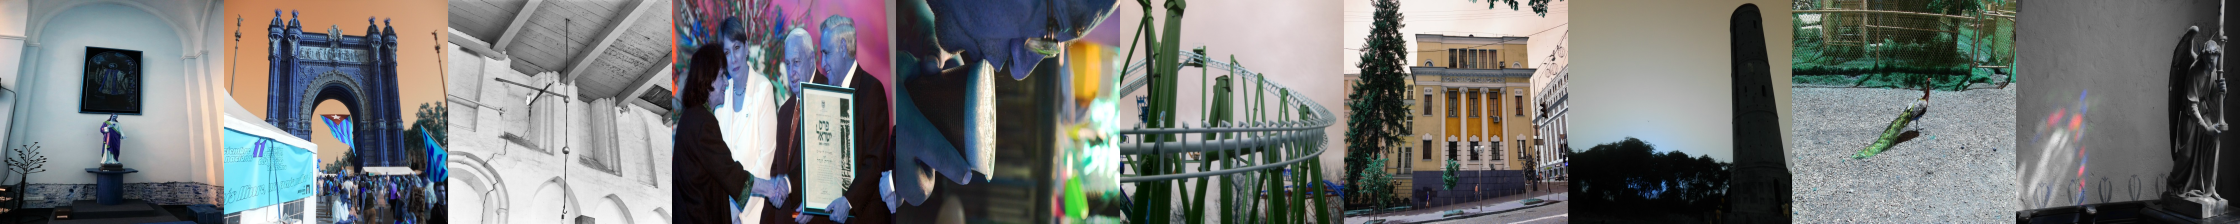

 
 
 
 
 --------------------------------------- 
 
 
 



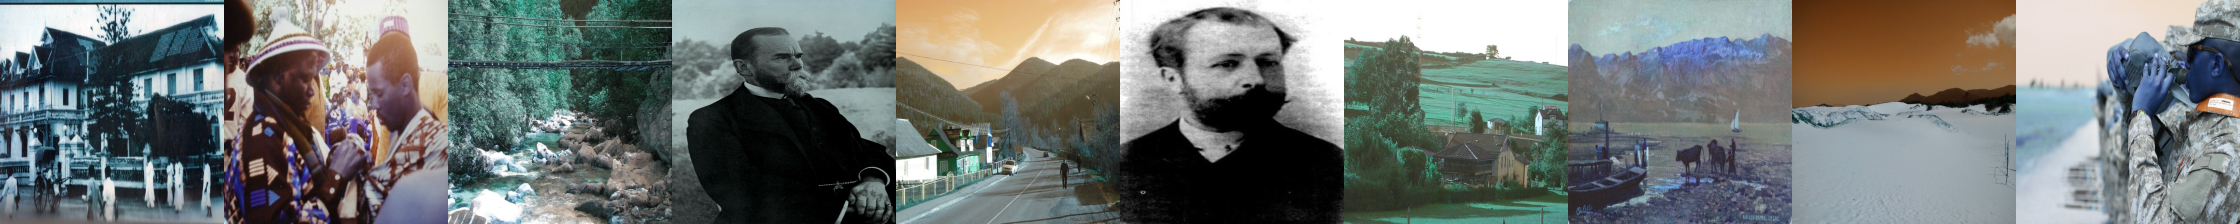

In [0]:
nonlandmarks = []

islandmark = []

with open(F'/content/drive/My Drive/imagenet1000.txt') as f:
  imagenet = eval(f.read())

discrim_model_2 = ResNet50(include_top=True, weights='imagenet', input_shape=(224, 224, 3))

# Places365 Model
discrim_model = VGG16_Places365(weights='places')    
class_information = pd.read_csv(F'/content/drive/My Drive/categories_places365_extended.csv')


for tar in range(1):
    if tar < 10:
        tar_id = "00" + str(tar+1)
    else:
        tar_id = "0" + str(tar+1)

    tar_images = []
    tar_ids = []

    def pickfiles(dirr):
      count = 0
      for f in os.listdir(dirr):
        if os.path.isfile(dirr + "/" + f):
            tar_images.append(dirr + "/" + f)
            tar_ids.append(f[:-4])
            count += 1
        else:
            count += pickfiles(dirr + "/" + f)
      return count

    download_file("https://s3.amazonaws.com/google-landmark/test/images_{}.tar".format(tar_id), f"images{tar_id}.tar", bar=False)
    tar = tarfile.open(f'images{tar_id}.tar')
    tar.extractall(f"imagesfolder{tar_id}")
    tar.close()

    os.unlink(f"images{tar_id}.tar")

    total = pickfiles(f"imagesfolder{tar_id}")
    print(tar, total, len(tar_ids))
        
    
    N = total
    batchsize = 1000
    conf_list = []
    y_pred_list = []
    validM = N // batchsize + int(N % batchsize > 0)


    categories = list(imagenet.values())

    topn = 5
    for i in range(validM):
        temp = tar_images[i * batchsize:min(N, (i + 1) * batchsize)]
        og_im = []
        batch_images_2 = []
        for t in temp:
            og_im.append(t)
            im = cv2.imread(t)
            im = cv2.resize(im, (224, 224), interpolation=cv2.INTER_AREA)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            batch_images_2.append(im)



        p0, p1, p2 = [], [], []
        isLandmark = []
        batch_images_2 = np.array(batch_images_2)
        all_preds = discrim_model_2.predict(batch_images_2, use_multiprocessing=True, workers = 8, batch_size=128)
        all_preds = decode_predictions(all_preds)
        # Loop through all images
        for (i, image) in enumerate(batch_images_2):
    
            # Predict Top N Image Classes
            image = np.expand_dims(image, 0)
            topn_preds = np.argsort(discrim_model.predict(image)[0])[::-1][0:topn]
            image_preds = all_preds[i]

            images0 = image_preds[0]
            images1 = image_preds[1]
            images2 = image_preds[2]
            images3 = image_preds[3]
            num_landmark = 0
            if (isImageLandmark(categories, images0[2], images0[1])):
                num_landmark += 1
              
            if (isImageLandmark(categories, images1[2], images1[1])):
                num_landmark += 1

            if (isImageLandmark(categories, images2[2], images2[1])):
                num_landmark += 1
          
            places0 = topn_preds[0]
            places1 = topn_preds[1]
            places2 = topn_preds[2]
            p0_landmark = class_information.loc[places0, ['landmark']][0]
            p1_landmark = class_information.loc[places1, ['landmark']][0]
            p2_landmark = class_information.loc[places2, ['landmark']][0]
            if (p0_landmark == 1): 
                num_landmark += 1
            if (p1_landmark == 1):
                num_landmark += 1
            if (p2_landmark == 1): 
                num_landmark += 1

            if(num_landmark < 6):
              
              nonlandmarks.append(og_im[i])
            else:
              islandmark.append(og_im[i])
from google.colab.patches import cv2_imshow
imgs = []
for img in nonlandmarks[:10]:
  im = cv2.imread(img)
  im = cv2.resize(im, (224, 224), interpolation=cv2.INTER_AREA)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  imgs.append(im)

imgs = np.hstack(imgs)
cv2_imshow(imgs)

print(" \r\n \r\n \r\n \r\n --------------------------------------- \r\n \r\n \r\n \r\n")
imgs = []
for img in islandmark[-10:]:
  im = cv2.imread(img)
  im = cv2.resize(im, (224, 224), interpolation=cv2.INTER_AREA)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  imgs.append(im)

imgs = np.hstack(imgs)
cv2_imshow(imgs)

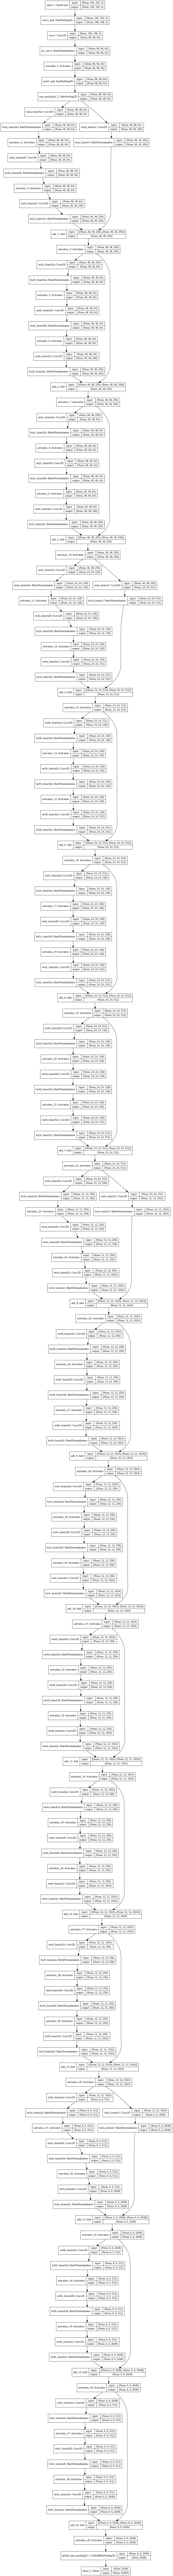

In [0]:
from keras.utils import plot_model
plot_model(model2, show_shapes = True, to_file='/model.png')

[Text(0, 0.5, 'Number of images'), Text(0.5, 0, 'Landmarks')]

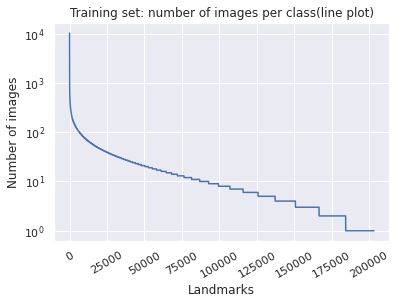

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os

sns.set()
plt.title('Training set: number of images per class(line plot)')
sns.set_color_codes("pastel")
landmarks_fold = pd.DataFrame(train['landmark_id'].value_counts())
landmarks_fold.reset_index(inplace=True)
landmarks_fold.columns = ['landmark_id','count']
ax = landmarks_fold['count'].plot(logy=True, grid=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=30)
ax.set(xlabel="Landmarks", ylabel="Number of images")

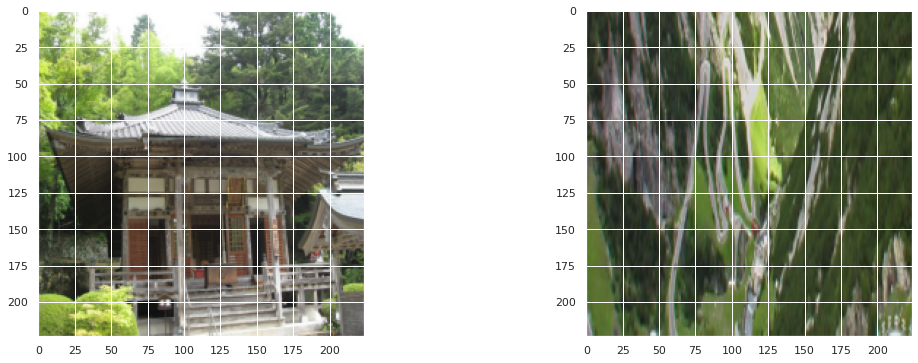

In [0]:
#from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

img1 = utils.load_img('imagesfolder001/0/0/8/00834b659fab41c6.jpg', target_size=(224, 224))
img2 = utils.load_img('imagesfolder001/0/0/8/00834d658d5cb214.jpg', target_size=(224, 224))
plt.rcParams['figure.figsize'] = (18, 6)
f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
ax[1].imshow(img2)



(1, 192, 192, 3)


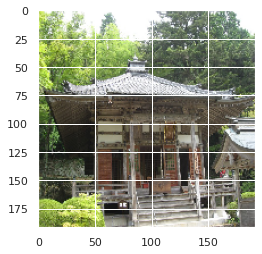

(1, 96, 96, 64)


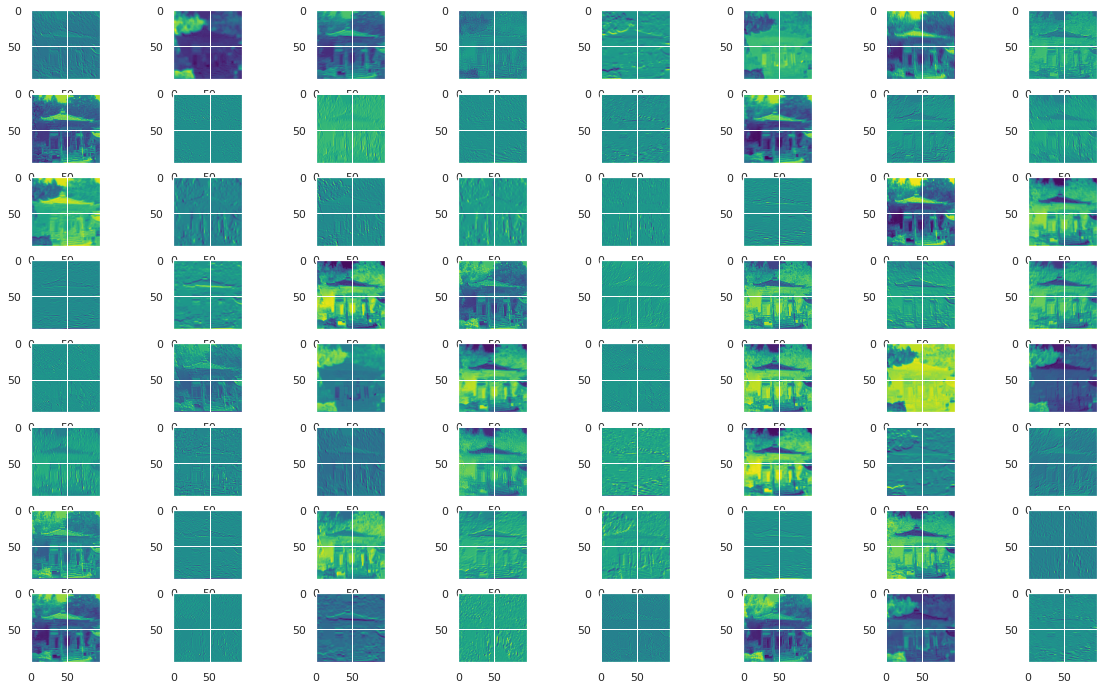

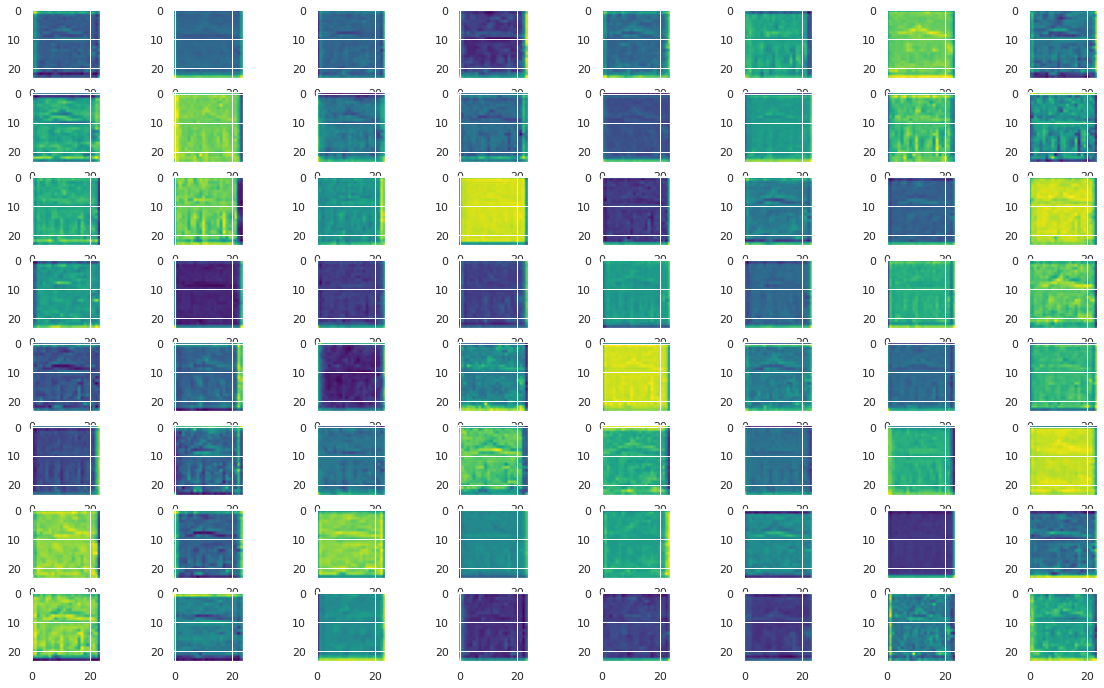

In [0]:
#reference - https://www.cloudera.com/tutorials/building-a-convolutional-neural-network-model.html

from keras.preprocessing import image
import numpy as np
img = image.load_img(img_path, target_size=(192, 192))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img_tensor[0])
plt.show()
from keras import models
layer_outputs = [layer.output for layer in model.layers[1:]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[1]
print(first_layer_activation.shape)

def display_outputs(activations, col_size, row_size, act_index):
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='viridis')
            activation_index += 1

display_outputs(activations, 8, 8, 1)

display_outputs(activations, 8, 8, 50)


